# Séance 4 - Réseau récurrent

Dans cette séance nous allons entraîner un modèle à copier le style de poésie de Beaudelaire, spécifiquement l'oeuvre *Les fleurs du mal*. Ce TP est largement inspiré du cours du [CNAM](https://cedric.cnam.fr/~thomen/cours/US330X/tpRNNs.html) que l'on a adapté ici.

Pour cela, nous utiliserons le projet [Gutenberg](https://www.gutenberg.org) qui permet l'accès l'ensemble des oeuvres littéraires classique gratuitement. C'est sur ce dataset, entre autres, que les LLM s'entraînent.

Commençons par importer les packages dont nous aurons besoin.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

import tensorflow as tf
from tensorflow import keras

Après avoir chargé dans l'environnement le fichier .txt de poésie, nous devons le travailler un peu pour l'exploiter. Quand on regarde le détail du fichier, on voit qu'il y a du texte qui n'est pas de la poésie. Nous décidons de n'exploiter que les poèmes.

In [2]:
start = False
book = open("Beaudelaire.txt", 'r' , encoding = 'utf8')
lines = book.readlines()
verses = []

for line in lines:
 line = line.strip().lower()
 if("AU LECTEUR".lower() in line and start==False):
  start = True
 if("End of the Project Gutenberg EBook of Les Fleurs du Mal, by Charles Baudelaire".lower() in line):
  break
 if(start==False or len(line) == 0):
  continue
 verses.append(line)

book.close()
text = " ".join(verses)
characters = sorted(set([character for character in text]))
n_characters = len(characters)

On décide ici de le découper en séquence de 32 caractères et de se décaler d'un caractère à chaque fois. Nous allons donc prédire le caractère suivant à partir des 32 caractères précédents.
Construisons deux listes qui, une fois transformée, deviendront $X$ et $y$.

**Consigne** : Compléter la cellule suivante avec les informations précédentes.

In [3]:
sequence_length = 32
stride = 1
sequences = []
y_character = []
for index in range(0, len(text) - sequence_length, stride):
    sequences.append(text[index:(index + sequence_length)])
    y_character.append(text[index + sequence_length])

Un réseau de neurone ne comprend pas le texte, donc nous devrons jongler entre nombre et caractères. Pour cela, nous créons deux dictionnaires pour traduire ces deux visions.

In [4]:
character_to_index = dict((character, index) for index, character in enumerate(characters))
index_to_character = dict((index, character) for index, character in enumerate(characters))

Nous sommes maintenant prêt pour renseigner $X$ et $y$. La matrice $X$ sera de taille $n \times N \times C$ avec:
* $n$ : le nombre de séquence exemples
* $N$ : la longueur de la séquence que l'on considère, ici 32
* $C$ : le nombre de caractères différents, ici stocké dans la variable *n_characters*

La matrice $y$ sera de taille $n\times C$. Les deux matrices seront de types booléens avec la valeur *True* à l'index du caractères représenté.

**Consigne** : Remplir la cellule suivante avec les informations précédentes. On utilisera le dictionnaire *character_to_index*.

In [5]:
X = np.zeros((len(sequences), sequence_length, n_characters), dtype=bool)
y = np.zeros((len(sequences), n_characters), dtype=bool)

for row, sequence in enumerate(sequences):
    for position, character in enumerate(sequence):
        X[row][position][character_to_index[character]] = True
    y[row][character_to_index[y_character[row]]] = True

Découpons à présent $X$ et $y$ en un jeu de test et un jeu d'entraînement. Aussi, nous allons sauvegarder ces matrices au cas où nous souhaiterions ne pas avoir à relancer ce preprocessing.

In [6]:
train_size = 0.8
train_index = int(round(len(sequences)*train_size))
X_train = X[:train_index,:,:]
y_train = y[:train_index,:]

X_test = X[train_index:,:,:]
y_test = y[train_index:,:]

## Modélisation

Dans cet exemple, nous allons définir un réseau récurrent avec les neurones de bases : pas de LSTM ou GRU.

Un neurone *SimpleRNN* possède les mêmes attributs qu'un neurones classique en plus de deux paramètres majeurs:
* **return_sequences**: si l'on doit renvoyer la totalité de la séquence ou seulement la dernière valeur
* **unroll**: permet d'accélérer l'entraînement du réseau de neurone au prix de plus de mémoire impliquée

**Consigne** : Compléter la cellule suivante pour définir le réseau de neurones avec les informations précédentes.

In [7]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(128, return_sequences=True, activation="relu", kernel_initializer="he_normal", input_shape=(sequence_length, n_characters), unroll=True),
    keras.layers.LayerNormalization(),
    keras.layers.SimpleRNN(64, return_sequences=False, activation="relu", kernel_initializer="he_normal", unroll=True),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(units=n_characters, activation='softmax')
])

model.summary()

2024-09-18 21:45:18.093797: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-18 21:45:18.093815: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-18 21:45:18.093820: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-18 21:45:18.093835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-18 21:45:18.093846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/theo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32, 128)        │        23,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 32, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │         3,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,702 (170.71 KB)

 Trainable params: 43,702 (170.71 KB)

 Non-trainable params: 0 (0.00 B)

Pour éviter l'overfitting, on se propose d'exploiter la mécanique d'[EarlyStopping](https://keras.io/api/callbacks/early_stopping/).

**Consigne** : Compléter la cellule suivante pour compiler le réseau de neurones et l'entraîner avec la mécanique d'EarlyStopping à paramétrer.

In [8]:
batch_size = 64
n_epochs = 20
learning_rate = 5e-4
weight_decay = 1e-4

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
callbacks = [early_stopping]

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/20


2024-09-18 21:45:19.458110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1699/1699 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.2840 - loss: 2.6271 - val_accuracy: 0.4075 - val_loss: 1.9879
Epoch 2/20
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 78s 46ms/step - accuracy: 0.4221 - loss: 1.9206 - val_accuracy: 0.4347 - val_loss: 1.8644
Epoch 3/20
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.4507 - loss: 1.7926 - val_accuracy: 0.4552 - val_loss: 1.8015
Epoch 4/20
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.4673 - loss: 1.7251 - val_accuracy: 0.4629 - val_loss: 1.7717
Epoch 5/20
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 78s 46ms/step - accuracy: 0.4818 - loss: 1.6728 - val_accuracy: 0.4731 - val_loss: 1.7392
Epoch 6/20
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 78s 46ms/step - accuracy: 0.4919 - loss: 1.6340 - val_accuracy: 0.4788 - val_loss: 1.7297
Epoch 7/20
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.5012 - loss: 1.5972 - val_accuracy: 0.4783 - val_loss: 1.7107
Epoch 8/20
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.5090 - loss: 1.56

L'entraînement étant terminé, visualisons sa courbe d'entraînement.

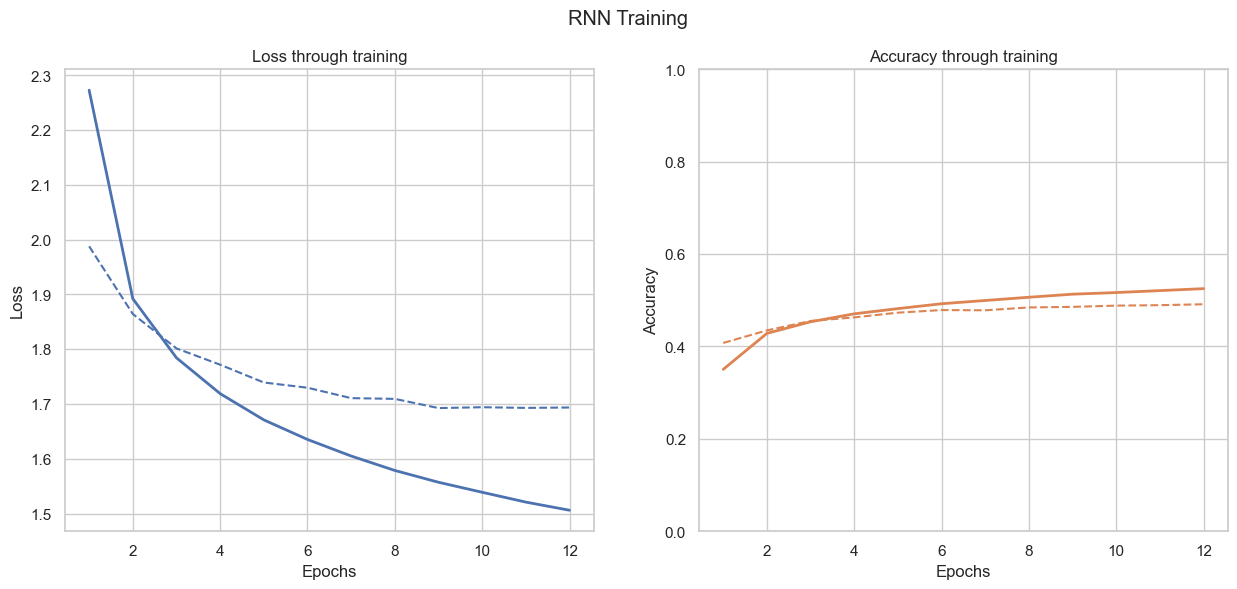

In [9]:
historic = pd.DataFrame(history.history)
figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
epochs = range(1, historic.shape[0]+1)

for index, (metric_name, axis) in enumerate(zip(["loss", "accuracy"], [axis_1, axis_2])):
  color = sns.color_palette()[index]
  axis.plot(epochs, historic[metric_name], lw=2, color=color)
  axis.plot(epochs, historic["val_" + metric_name], ls="--", color=color)

  if metric_name == "accuracy": axis.set_ylim(0, 1)
  axis.set_ylabel(metric_name.capitalize())
  axis.set_xlabel("Epochs")
  axis.set_title("%s through training" % metric_name.capitalize())


plt.suptitle("RNN Training")
plt.show()

Sauvegardons le modèle pour pouvoir l'utiliser plus tard, ou sur un autre notebook par exemple.

In [10]:
def save_model(model, name):
  model_json = model.to_json()
  with open(name + ".json", "w") as json_file:
    json_file.write(model_json)
  model.save_weights(name+".weights.h5")

save_model(model, "SimpleRNN")

Importons le modèle que l'on vient de sauvegarder sous un autre alias.

In [11]:
from keras.models import model_from_json


def load_model(name):
  with open(name + ".json", "r") as json_file:
    model = model_from_json(json_file.read())
  model.load_weights(name+".weights.h5")
  return model


model_SimpleRNN = load_model("SimpleRNN")

**Consignes** : Compléter la cellule suivante pour vérifier que les performances sont bien celles que nous connaissons.

In [12]:
model_SimpleRNN.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),metrics=['accuracy'])
score = model_SimpleRNN.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: %.02f%%" % (score[1]*100))

Test accuracy: 48.57%


## Génération de texte

On souhaite exploiter le modèle pour générer de la poésie dans le style de Beaudelaire.
On se propose de commencer par un bout d'un poème au hasard.

In [13]:
seed = 2025
sequence = ""
for index in range(sequence_length):
 character = index_to_character[np.argmax(X_train[seed, index, :])]
 sequence += character

print("Start sequence: " + sequence)

Start sequence: mère épouvantée et pleine de bla


Pour choisir le prochain caractère, nous pouvons simplement sélectionner le caractère le plus probable prédit par le modèle. Cette approche peut amener le modèle à dégénérer.

Nous allons essayer de sélectionner aléatoirement l'index du prochain caractère en s'appuyant sur le vecteur de probabilité produit par le réseau de neurone définit plus tôt.

### Température

On considère un vecteur $u = (u_1, u_2, \ldots, u_d)$ et un paramètre $\tau > 0$ que l'on appelle la température. On peut construire le vecteur $v = (v_1, v_2, \ldots, v_d)$ à partir de $u$ et de $\tau$ comme:

$$\forall i \leqslant d, \quad v_i = \frac{\displaystyle \exp\left(\frac{u_i}{\tau}\right)}{\displaystyle \sum_{j=1}^d \exp\left(\frac{u_j}{\tau}\right)}$$

Cela ressemble à la fonction softmax mais paramétrer par la température $\tau$.

**Consigne** : Ecrire une fonction nommé `sampling` qui prend en paramètre un vecteur de probabilité et la température. Cette fonction doit renvoyer un index sélectionné selon le vecteur de probabilité définit par la température. On s'appuiera sur le travail de la cellule précédente.

In [14]:
def sampling(probabilities, temperature=1.0):
    probabilities = np.asarray(probabilities).astype('float64')
    probabilities = pow(probabilities, 1.0 / temperature)
    probabilities /= np.sum(probabilities)
    probabilities = np.random.multinomial(n=1, pvals=probabilities, size=1)
    return np.argmax(probabilities)

Maintenant que nous sommes capables de sélectionner le prochain caractère avec plus de justesse, il ne nous restes plus qu'à générer la suite de la phrase !

In [15]:
def generate_sequence(start, length, model, temperature=1):
  sequence = np.zeros((1, sequence_length, n_characters), dtype=bool)
  for position, character in enumerate(start):
    sequence[0][position][character_to_index[character]] = True

  generated_sequence = start


  for _ in range(length):
    probabilities = model.predict(sequence, verbose=0)[0]
    next_index = sampling(probabilities, temperature=temperature)
    character = index_to_character[next_index]
    generated_sequence += character

    for index in range(sequence_length-1): sequence[0, index, :] = sequence[0, index+1, :]

    sequence[0, sequence_length-1, :] = 0
    sequence[0, sequence_length-1, next_index] = 1


  return generated_sequence

Avec l'ensemble du travail, on a :

In [16]:
generate_sequence(start=sequence, length=50, model=model_SimpleRNN, temperature=0.5)

'mère épouvantée et pleine de blanche et toujours un soir sous sans ma jamais les i'

## Pour continuer

Choisir une ou plusieurs pistes de recherche parmi les suivantes. Il est possible de choisir une autre direction, mais elle doit être validé auparavant.

1. Nous avons défini une seule architecture. On peut en essayer d'autres et les comparer à la fois avec les courbes d'apprentissages mais également avec la génération de texte.
2. Il existe une couche [`Embedding`](https://keras.io/api/layers/core_layers/embedding/). On se propose de l'exploiter et de mesurer ses performances.
